In [26]:
!pip install tensorflow-probability
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /private/var/folders/zf/p75y8jj52c72dh5cv6ys92pm0000gn/T/pip-req-build-aff5ms3z
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/zf/p75y8jj52c72dh5cv6ys92pm0000gn/T/pip-req-build-aff5ms3z
  Resolved https://github.com/tensorflow/docs to commit 476e61b24de218a85fbd71edffdd314c3c6a8b61
  Preparing metadata (setup.py) ... done


In [27]:
!pip install tensorflow_datasets

In [28]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

### Loading dataset

In [29]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [30]:
X_train = train_images[:50_000] / 255.
X_val = train_images[50_000:] / 255.
X_test = test_images / 255.

### Keras example
https://keras.io/examples/generative/vae/

In [33]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(tf.shape(z_log_var))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

##### Encoder

In [35]:
latent_dim = 20

encoder_inputs = keras.Input(shape=[28, 28])
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(160, activation="relu")(x)
x = layers.Dense(80, activation="relu")(x)
x = layers.Dense(40, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_5[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 160)          125600      ['flatten_1[0][0]']              
                                                                                                  
 dense_9 (Dense)                (None, 80)           12880       ['dense_8[0][0]']                
                                                                                            

##### Decoder

In [37]:
latent_inputs = keras.Input(shape=[latent_dim])
x = layers.Dense(40, activation="relu")(latent_inputs)
x = layers.Dense(80, activation="relu")(x)
x = layers.Dense(160, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape([28, 28])(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_15 (Dense)            (None, 40)                840       
                                                                 
 dense_16 (Dense)            (None, 80)                3280      
                                                                 
 dense_17 (Dense)            (None, 160)               12960     
                                                                 
 dense_18 (Dense)            (None, 784)               126224    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 143,304
Trainable params: 143,304
Non-trainab

In [38]:
_, _, z = encoder(encoder_inputs)
reconstructions = decoder(z)
variational_ae = keras.Model(inputs=[encoder_inputs], outputs=[reconstructions])

In [39]:
latent_loss = -0.5 * keras.backend.sum(1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var), axis=-1)
variational_ae.add_loss(keras.backend.mean(latent_loss)/784)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [40]:
history = variational_ae.fit(X_train, X_train, epochs=40, batch_size=128, validation_data=[X_val, X_val])

Epoch 1/40
391/391 [==============================] - 4s 7ms/step - loss: 0.2800 - val_loss: 0.2484
Epoch 2/40
391/391 [==============================] - 3s 7ms/step - loss: 0.2407 - val_loss: 0.2315
Epoch 3/40
391/391 [==============================] - 3s 7ms/step - loss: 0.2269 - val_loss: 0.2166
Epoch 4/40
391/391 [==============================] - 3s 7ms/step - loss: 0.2123 - val_loss: 0.2055
Epoch 5/40
391/391 [==============================] - 3s 7ms/step - loss: 0.2015 - val_loss: 0.1965
Epoch 6/40
391/391 [==============================] - 3s 7ms/step - loss: 0.1925 - val_loss: 0.1891
Epoch 7/40
391/391 [==============================] - 3s 7ms/step - loss: 0.1859 - val_loss: 0.1830
Epoch 8/40
391/391 [==============================] - 3s 7ms/step - loss: 0.1808 - val_loss: 0.1804
Epoch 9/40
391/391 [==============================] - 3s 7ms/step - loss: 0.1769 - val_loss: 0.1756
Epoch 10/40
391/391 [==============================] - 3s 7ms/step - loss: 0.1739 - val_loss: 0.1706

In [41]:
latent_tensor = tf.random.normal([6, latent_dim])

In [42]:
image = decoder(latent_tensor).numpy()

In [43]:
image[0].shape

(28, 28)

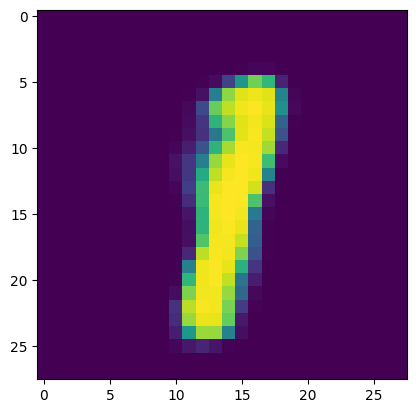

In [46]:
from matplotlib import pyplot as plt
ax, fig = plt.subplot(6)
for i in range(len(image)):
    ax[i].imshow(im)

### Class for CVAE 
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb#scrollTo=VGLbvBEmjK0a